## Nanodegree Project 1 - Calculating budget for traveling Sicily
The project is based on Airbnb data for Sicily, retrieved from http://insideairbnb.com/. 
The target of the project is to explore relationship between rental fee, locations and accomodation characteristics of the airbnb offer. The project will analysis the forecasted cost for accomodation of an hypothetical 2 weeks travel in Sicily, considering variation in travelling preferences,  destinations and requested room characteristics (and assuming to stay in some Airbnb or Airbnb-like houses).  

## Step 2: Project questions 
The traveler is assumed to have the following preferences. 

Mandatory requirement:
- Travel will be a family holyday, for a family composed by two parents and 1 kid
- Duration will be 14 night
- Private room, private bath

Negotiable requirement:
- Some review and good rating (>7)
- Second sleeping room 
- Second bathroom

And -of course- there is a budget: we assume to allocate \$2000 for accomodations (\$143 per night), and we want 75% of available solutions to stay within the budget. 

#### Question 1

Is it doable? Do we see 75 percent of listings at a cost lower than \$143 per night, once we have filtered for mandatory requirements? Can we accomodate in the budget limit also  negotiable ones? Among negotiable parameters, which are the ones with higher positive correlation with costs?  

#### Question 2

Let's assume the traveler downloaded from the internet the set of "best 20 location to visit in Sicily"; which is the impact of introducing in the mandatory requirements the stay on one of the 20 locations? How many of them stays within budget limits? 

#### Question 3

Looking again in the internet, the traveler visited https://www.voyagetips.com/it/itinerari-2-settimane-in-sicilia/ where he found suggestions for a trip touching several locations. Which is expected cost change with this option? What if we assume to leave a August 1st this year?

## Step 3.a: Loading and preparing data

Considering questions above, among available data set, we may want to use of the following files:
- "listings_full.csv": descriptions of the different structures, including position, price, charcteristics, rating etc 
- "calendar.csv": basically price per date per accomodation. 
- "reviews_short.csv": each rows corresponds to a stay review and provides a reference to the evaluated structure and a date for the review 
- "reviews_full.csv": for each review listed in the previous file, adds reviewer id and the text provided as a review 

All dataset were initially explored in a dedicated notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
#import cufflinks as cf
%matplotlib inline

In [2]:
cd ".\\Data"

C:\Users\Roberto\UdacityNanodegreeAirbnb\Data


Based on the information gathered in first data exploration, I filter among available columns the subset that is more promising for our target analysis

In [3]:
listings_needed_col=[
    'id', 'last_scraped', 'name', 'description','neighborhood_overview', 'host_since', 'host_location', 
    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood',
    'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates', 
    'bathrooms', 'bathrooms_text','bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'calendar_updated', 
    'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
    'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
    'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
    'license', 'instant_bookable', 'reviews_per_month']

In [4]:
listings=pd.read_csv('listings_full.csv', usecols=listings_needed_col)

C:\Users\Roberto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


As the rental price will be the main variable under analysis, let's first examine values in the price column. Unfortunately, it is not stored as numerical values: 

In [5]:
listings[['price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49659 entries, 0 to 49658
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   49659 non-null  object
dtypes: object(1)
memory usage: 388.1+ KB


In [6]:
listings[['price']].describe()

,price
count,49659
unique,729
top,$50.00
freq,3703


In [7]:
listings['price'].value_counts()

$50.00       3703
$60.00       2815
$40.00       2339
$70.00       2013
$100.00      1995
             ... 
$2,559.00       1
$906.00         1
$1,180.00       1
$743.00         1
$481.00         1
Name: price, Length: 729, dtype: int64

Apparently the reason why prices were stored as string is the presence of the '$' symbol in the string and the usage of comma as a thousand separator. Let's check with a function is this is the only issue:

In [8]:
prices=list(listings['price'].unique())
def check_prices(prices):
    exceptions=0
    for p in prices:
        try:
            v=float(p.strip('$').replace(',',''))
        except:
            exceptions+=1
            print(p)
    print('{} exceptions found'.format(exceptions))        
check_prices(prices)

0 exceptions found


Knowing that the assumption is correct, let' modify the dataframe

In [9]:
def numerical_price(price):
    return float(price.strip('$').replace(',',''))

listings['price']=listings['price'].apply(lambda x: numerical_price(x)) 


Finally, it seams we have some outlier in the set. Let's check for 'big' values:

count    49659.000000
mean        93.213093
std        242.796749
min          9.000000
25%         45.000000
50%         60.000000
75%         95.000000
max      21000.000000
Name: price, dtype: float64
count      118.000000
mean      2943.432203
std       3671.752560
min       1007.000000
25%       1187.000000
50%       1540.000000
75%       2500.000000
max      21000.000000
Name: price, dtype: float64


<AxesSubplot:>

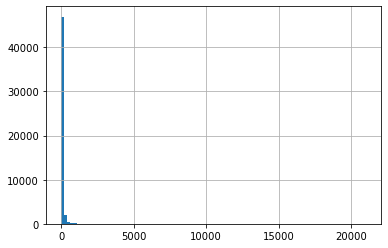

In [10]:
print(listings['price'].describe())
print(listings[listings['price']>1000]['price'].describe())
listings['price'].hist(bins=100)


In [11]:
listings[listings['price']>1000]['id'].count()

118

We have a small set of value much higher than the average. It is difficult to understand if this is due to really expensive accomodation or to some problem in the data. For the scope of the analysis, it is reasonable to drop this accomodations from the listing

In [12]:
listings=listings[listings['price']<1000]

count    49479.000000
mean        85.279492
std         82.564741
min          9.000000
25%         45.000000
50%         60.000000
75%         95.000000
max        999.000000
Name: price, dtype: float64


<AxesSubplot:>

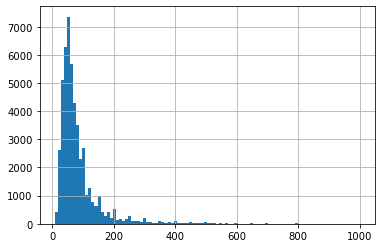

In [13]:
print(listings['price'].describe())
listings['price'].hist(bins=100)



So, we start from having 75% of listing below \$95 per night, well within the budget. Let's introduce mandatory requirement:
- Travel will be a family holyday, for a family composed by two parents and 1 kid
- Duration will be 14 night
- Private room, private bath

Requirement about number of travelers is most probably satisfied by the column 'bed', or by column bedrooms. Let's check the content  

In [14]:
listings[['beds','bedrooms']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49479 entries, 0 to 49658
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      49299 non-null  float64
 1   bedrooms  48118 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


In [15]:
listings[['beds','bedrooms']].describe()

,beds,bedrooms
count,49299.000000,48118.000000
mean,2.931195,1.843447
std,2.077344,1.085241
min,0.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,2.000000
75%,4.000000,2.000000
max,67.000000,40.000000


Both information are numeric (as desired) and available for most of the structures. We filter for beds >=3 and store the outcome in a new dataframe 'listings_target' that will collect structures satisfying all mandatory requirements. 

In [16]:
listings_target=listings[listings['beds']>=3]
listings_target[['beds']].describe()

,beds
count,24911.000000
mean,4.375778
std,1.997342
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,67.000000


Regarding duration (2 weeks), not having a starting date we cannot yet look for actual availability. For the scope of the exercise we assume for now to look for a structure allowing to stay for 14 might (using maximum nights column) 

In [17]:
listings_target[['maximum_nights']].describe()

,maximum_nights
count,2.491100e+04
mean,9.043519e+04
std,1.361804e+07
min,1.000000e+00
25%,3.000000e+01
50%,1.124000e+03
75%,1.125000e+03
max,2.147484e+09


In [18]:
listings_target=listings_target[listings_target['maximum_nights']>=14]
listings_target[['maximum_nights']].describe()

,maximum_nights
count,2.445100e+04
mean,9.213641e+04
std,1.374554e+07
min,1.400000e+01
25%,3.000000e+01
50%,1.125000e+03
75%,1.125000e+03
max,2.147484e+09


Finally, let's filter for private room and private bath. Lets start investigating columns 'property_type', 'room_type'. Room type seems to carry desired info:

In [19]:
listings_target['room_type'].value_counts()

Entire home/apt    22288
Private room        2008
Hotel room           110
Shared room           45
Name: room_type, dtype: int64

In [20]:
listings_target=listings_target[listings_target['room_type']!="Shared room"]
listings_target['room_type'].value_counts()

Entire home/apt    22288
Private room        2008
Hotel room           110
Name: room_type, dtype: int64

For bathrooms requirements, promising columns are 'bathrooms', 'bathrooms_text'. Unfortunately 'bathrooms' column is not compiled, and the info is in bathroom text:

In [21]:
listings_target[['bathrooms','bathrooms_text']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24406 entries, 0 to 49656
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       0 non-null      float64
 1   bathrooms_text  24402 non-null  object 
dtypes: float64(1), object(1)
memory usage: 572.0+ KB


In [22]:
listings_target['bathrooms_text'].value_counts()

1 bath               11832
2 baths               6555
3 baths               1624
1.5 baths             1146
1 private bath         796
4 baths                649
2.5 baths              556
5 baths                312
1 shared bath          180
3.5 baths              166
6 baths                128
4.5 baths               85
2 shared baths          66
7 baths                 50
5.5 baths               34
8 baths                 25
1.5 shared baths        24
3 shared baths          23
10 baths                21
7.5 baths               16
6.5 baths               15
0 baths                 14
9 baths                 12
2.5 shared baths        11
4 shared baths          10
5 shared baths           9
Half-bath                6
11 baths                 5
3.5 shared baths         5
7 shared baths           4
8.5 baths                3
0 shared baths           3
5.5 shared baths         3
4.5 shared baths         3
10.5 baths               2
15 baths                 2
9.5 baths                2
S

Looking at column content, we can proceed as follow: 
- we extract the numerical information in the initial substring of 'bathroom_text' and store it as a float in the 'bathroom' column
- we create a new column named 'private bathroom' storing boleean values based on the presence of the keyword 'shared' in the text description  
Note that three cases where description doesn't start with a number must be treated separately. Considering text, we will set them to 0.

In [23]:
def count_bath(x):
    bath=str(x).split(' ')[0]
    try:
        bath_number=float(bath)
    except:
        bath_number=0
    return bath_number

def not_shared_bath(x):
    bath=str(x).split(' ')
    return not(('shared' in bath) or ('Shared' in bath) or ('SHARED' in bath)) 

listings_target['bathrooms']=listings_target['bathrooms_text'].apply(lambda x: count_bath(x)) 
listings_target['private bath']=listings_target['bathrooms_text'].apply(lambda x: not_shared_bath(x)) 
listings['bathrooms']=listings['bathrooms_text'].apply(lambda x: count_bath(x)) 
listings['private bath']=listings['bathrooms_text'].apply(lambda x: not_shared_bath(x)) 


In [24]:
listings_target['bathrooms'].value_counts()

1.0     12808
2.0      6621
3.0      1647
1.5      1170
4.0       659
2.5       567
5.0       321
3.5       171
6.0       128
4.5        88
7.0        54
5.5        37
0.0        26
8.0        25
10.0       21
7.5        16
6.5        15
9.0        13
11.0        5
8.5         3
9.5         2
15.0        2
10.5        2
12.0        1
Name: bathrooms, dtype: int64

In [25]:
listings_target['private bath'].value_counts()

True     24062
False      344
Name: private bath, dtype: int64

so we finally have the list of accomodation satysfying mandatory requirement; luckily, the list is till large enough to allow some statistics and we still are within budget constraints (75 percentile is now \$120).

In [26]:
listings_target=listings_target[listings_target['private bath']]
listings_target=listings_target[listings_target['bathrooms']>0]

In [27]:
listings_target.describe()

,id,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,calendar_updated,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,2.403700e+04,0.0,24037.000000,24037.000000,23782.000000,24037.000000,24037.000000,24037.000000,2.403700e+04,0.0,...,24037.000000,24037.000000,14834.000000,14821.000000,14827.000000,14812.000000,14815.000000,14811.000000,14812.000000,15283.000000
mean,2.422956e+07,NaN,5.918542,1.707430,2.428097,4.368266,105.664018,3.568707,9.371207e+04,NaN,...,1.129592,0.010900,93.482608,9.524931,9.501990,9.761005,9.733581,9.427588,9.327370,0.355335
std,1.406174e+07,NaN,2.316493,1.069435,1.134208,1.935666,102.785295,9.280605,1.386341e+07,NaN,...,2.987739,0.132054,9.608272,0.986482,0.987945,0.770286,0.821584,0.960358,1.053417,0.552909
min,7.011000e+03,NaN,1.000000,1.000000,1.000000,3.000000,9.000000,1.000000,1.400000e+01,NaN,...,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,1.294126e+07,NaN,4.000000,1.000000,2.000000,3.000000,50.000000,2.000000,3.000000e+01,NaN,...,0.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.070000
50%,2.414338e+07,NaN,6.000000,1.000000,2.000000,4.000000,75.000000,3.000000,1.125000e+03,NaN,...,0.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.160000
75%,3.590961e+07,NaN,7.000000,2.000000,3.000000,5.000000,120.000000,4.000000,1.125000e+03,NaN,...,1.000000,0.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.400000
max,4.888828e+07,NaN,16.000000,15.000000,14.000000,66.000000,999.000000,1000.000000,2.147484e+09,NaN,...,63.000000,5.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.160000


Before trying to answer to first question, we also need to have the info ready to address 'negotiable preferences', namely second bedroom, second bathroom, some review and good review rating.

For second bedroom and bathroom we already have numerical values ready:

<AxesSubplot:>

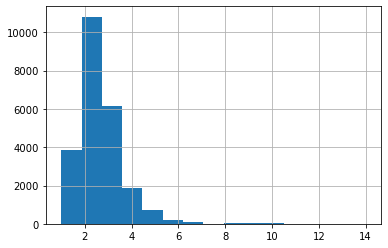

In [28]:
listings_target['bedrooms'].hist(bins=15)

For number of reviews, we also have numerical, ready to go columns (number_of_reviews, number_of_reviews_l30d). As we can see in the graph below, ratings columns is also available with numerical variable ranging from 0 to 100); in this case we have a number of NaN, corresponding to accomodation who didn't receive any rating.

<AxesSubplot:>

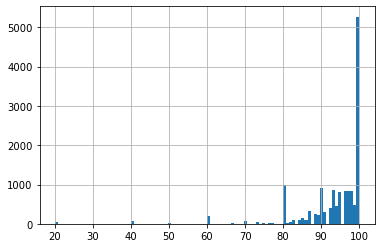

In [29]:
listings_target['review_scores_rating'].hist(bins=100)

## Step 3b: addressing questions

#### Question 1:
Do we see 75 percent of listings at a cost lower than \$143 per night, once we have filtered for mandatory requirements? Can we accomodate in the budget limit also  negotiable ones? Among negotiable parameters, which are the ones with higher positive correlation with costs?  

Following plots shows price distribution for mandatory requirement

Text(162.85714285714286, 0.8135374630777551, '81% of listings are within budget')

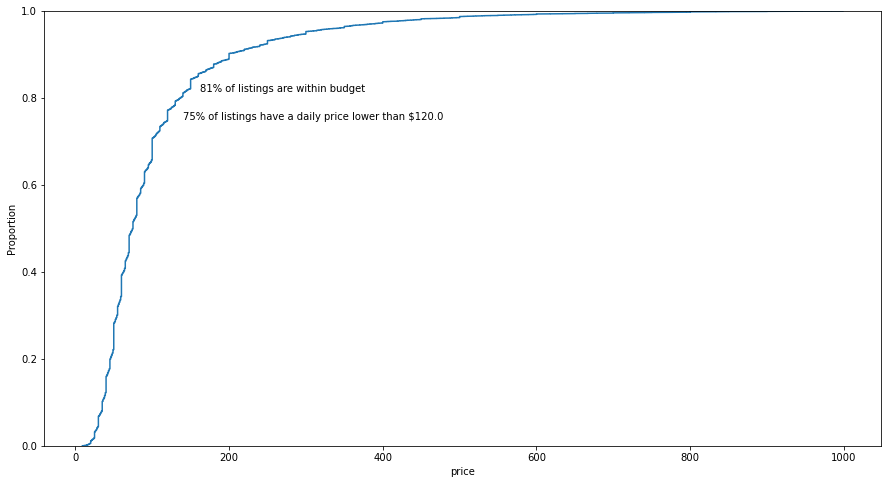

In [30]:
target_per_night=2000/14
percent_within_budget=listings_target[listings_target['price']<=target_per_night]['price'].count()/listings_target['price'].count()
percentile75= listings_target['price'].describe()['75%']
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.ecdfplot(data=listings_target, ax=ax, x="price")
ax.annotate('75% of listings have a daily price lower than \${}'.format(percentile75), xy=(percentile75+20, .75))
ax.annotate('{0:.0%} of listings are within budget'.format(percent_within_budget), xy=(target_per_night+20, percent_within_budget))


<AxesSubplot:xlabel='price'>

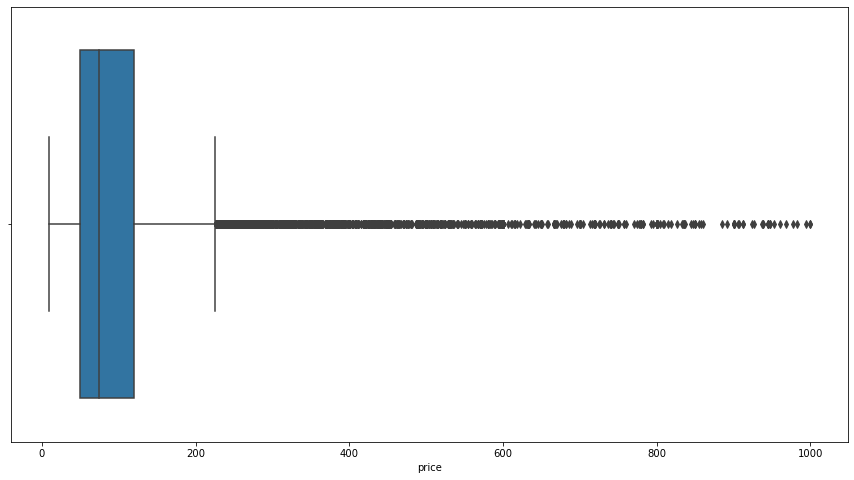

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.boxplot(data=listings_target, ax=ax, x="price")


Now we derive a new dataframe 'listings_target_negot', containing all structure satisfying both mandatory and negotiable requirements. After this step, we will plot distribution of price variables in the three cases (all listings, only mandatory req, all requirements)

In [32]:
listings_target_negot=listings_target[listings_target['bathrooms']>1]
listings_target_negot=listings_target_negot[listings_target_negot['bedrooms']>1]
listings_target_negot=listings_target_negot[listings_target_negot['review_scores_rating']>90]
results=pd.concat([listings['price'].describe().rename('All data'),listings_target['price'].describe().rename('Mandat.')], axis=1)
results=pd.concat([results,listings_target_negot['price'].describe().rename('Negot.')], axis=1)
print(results)

           All data       Mandat.       Negot.
count  49479.000000  24037.000000  5293.000000
mean      85.279492    105.664018   125.583034
std       82.564741    102.785295   107.276501
min        9.000000      9.000000    11.000000
25%       45.000000     50.000000    60.000000
50%       60.000000     75.000000    90.000000
75%       95.000000    120.000000   150.000000
max      999.000000    999.000000   999.000000


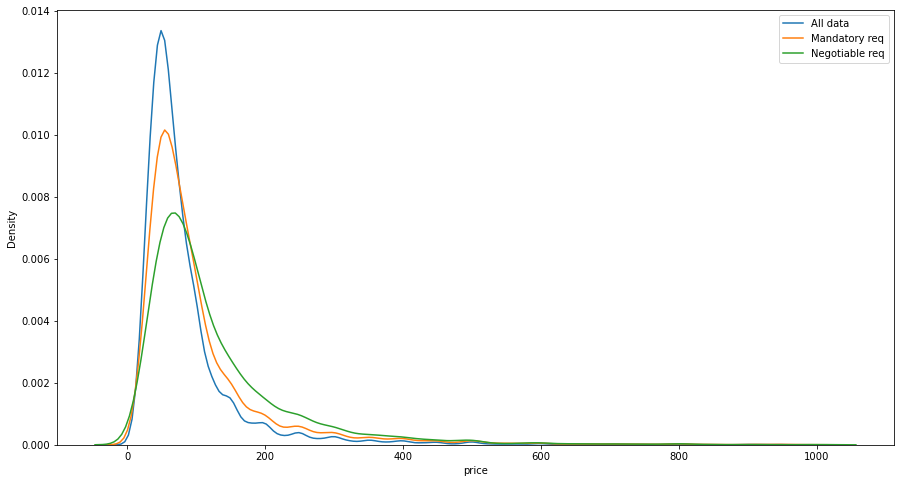

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.kdeplot(data=listings, ax=ax, x="price", label='All data')
sns.kdeplot(data=listings_target, ax=ax, x="price", label='Mandatory req')
sns.kdeplot(data=listings_target_negot, ax=ax, x="price", label='Negotiable req')
plt.legend()

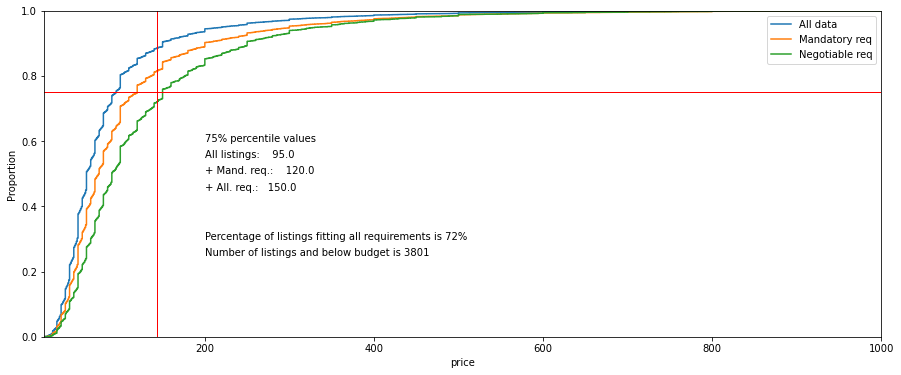

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
perc75_all= listings['price'].describe()['75%']
perc75_man= listings_target['price'].describe()['75%']
perc75_neg= listings_target_negot['price'].describe()['75%']
number_within_budget=listings_target_negot[listings_target_negot['price']<=target_per_night]['price'].count()
percent_within_budget=number_within_budget/listings_target_negot['price'].count()
sns.ecdfplot(data=listings, ax=ax, x="price", label='All data')
sns.ecdfplot(data=listings_target, ax=ax, x="price", label='Mandatory req')
sns.ecdfplot(data=listings_target_negot, ax=ax, x="price", label='Negotiable req')
ax.annotate('75% percentile values', xy=(200, .6))
ax.annotate('All listings:    {}'.format(perc75_all), xy=(200, .55))
ax.annotate('+ Mand. req.:    {}'.format(perc75_man), xy=(200, .5))
ax.annotate('+ All. req.:   {}'.format(perc75_neg), xy=(200, .45))
ax.annotate('Percentage of listings fitting all requirements is {0:.0%}'.format(percent_within_budget), xy=(200, .30))
ax.annotate('Number of listings and below budget is {}'.format(number_within_budget), xy=(200, .25))
ax.set(xlim=(10, 1000))
ax.plot([target_per_night, target_per_night],[0,1], color='red',linewidth=1)
ax.plot([0, 1000],[0.75,.75], color='red',linewidth=1)
plt.legend()


As we can see from the pictures, after inclusion of all additional requirements we are hitting our budget targets as only 72% of the listings are below target, while requirements was 75% (75 percentile is now at\$ 150).

Let's have a look statistical correlation of the additional parameters to price. To start this task, we consider a smaller dataframe including only columns of interest for the task.

In [35]:
reduced_list=['id', 'bathrooms', 'bedrooms',  'price',  'number_of_reviews', 'review_scores_rating']
listings_corr=listings_target[reduced_list]

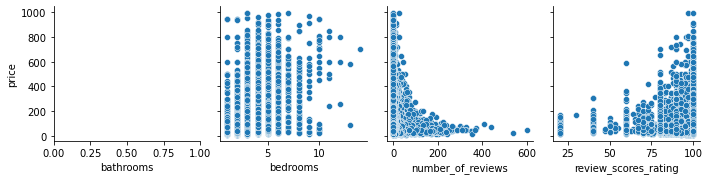

In [36]:
sns.pairplot(data=listings_corr, x_vars=['bathrooms', 'bedrooms',  'number_of_reviews', 'review_scores_rating'], y_vars=['price'])

In [37]:
listings_corr.corr()['price']

id                      0.110742
bathrooms               0.545726
bedrooms                0.487468
price                   1.000000
number_of_reviews      -0.115267
review_scores_rating    0.076071
Name: price, dtype: float64

<AxesSubplot:>

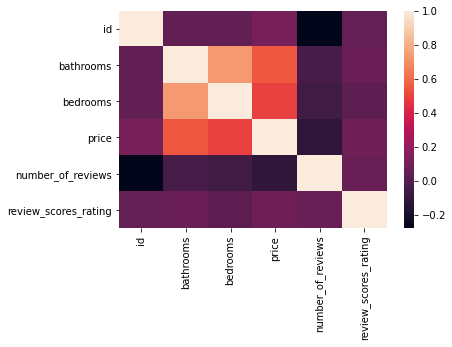

In [38]:
sns.heatmap(listings_corr.corr())

As we can see form correlation matrix and from heatmap, the additional rooms have an higher positive correlation, and it seems that additional bathrooms have a bit higher value compared to additional bedrooms. Interestingly, increased rating doesn't translate directly into additional price (positive correlation is low), I guess becouse raters evaluates 'value for money' ratio and cheaper accomodation may receive positive feedback if they meet expectations.

#### Question 2:
In second question, our traveler downloaded from the internet (e.g. from https://www.expedia.it/explore/mare-in-sicilia-le-20-localita-balneari-piu-belle) a list of top 20 recommendation for sites to be visited in Sicily, and is considering if adding as additional requirements the stay in one of these 20 locations and which of them is under budget constraints.   

As a first step, let's cut and past top location list into the notebook

In [39]:
expedia_recomm=set([
"Favignana",
"Sciacca",
"Mondello",
"Lampedusa",
"Altavilla Milicia",
"San Vito Lo Capo",
"Riserva dello Zingaro",
"Realmonte",
"Trapani",
"Brucoli",
"Giardini-Naxos",
"Lipari",
"Aci Trezza",
"Pantelleria",
"Riserva di Vendicari",
"Marzamemi",
"Cefalù",
"Taormina",
"Fontane Bianche",
"Capo d'Orlando"])

The list of recommmendation must be matched with the column "neighborhood_cleansed" in the listing dataframe (the column neighboorhood is much more messy in used formats) . However, some manual change may be needed in the recommendation list to ensure proper matching. First, let's check if any recommendation is missing in the neighborhood list and possibly why.

In [40]:
locations=set(listings['neighbourhood_cleansed'].unique())

In [41]:
both_lists=expedia_recomm.intersection(locations)
missing=expedia_recomm-both_lists

In [42]:
len(both_lists)

11

In [43]:
missing

{'Aci Trezza',
 'Brucoli',
 'Cefalù',
 'Fontane Bianche',
 'Lampedusa',
 'Marzamemi',
 'Mondello',
 'Riserva dello Zingaro',
 'Riserva di Vendicari'}

Missing localities are those not referring to an independent administrative unit (comune). The dictionary below create the needed matches

In [44]:
d={'Aci Trezza':'Aci Castello',
 'Brucoli':'Augusta',
 'Cefalù':'Cefal',
 'Fontane Bianche': 'Siracusa',
 'Lampedusa':'Lampedusa e Linosa',
 'Marzamemi':'Pachino',
 'Mondello':'Palermo',
 'Riserva dello Zingaro':'San Vito Lo Capo' ,
 'Riserva di Vendicari':'Noto'}

In [45]:
expedia_recomm_cleaned=expedia_recomm.union(set(d.values()))-set(d.keys())

In [46]:
len(expedia_recomm_cleaned)

19

(We moved from 20 to 19 becouse two recommended locations were actually referring to the same administative unit)

In [47]:
both_list=expedia_recomm_cleaned.intersection(locations)

In [48]:
len(both_list)

19

Once we know that the list of recommmended localities matches a column in the dataframe, we can introduce in the dataframes some filtering options:

In [49]:
listings_target['recomm']=listings_target['neighbourhood_cleansed'].isin(list(expedia_recomm_cleaned)) #Boolen, True if in the list
listings_target['recomm_neighbourood']=listings_target['neighbourhood_cleansed'] #either a top place or 'outside the list' label
listings_target['recomm_neighbourood'][listings_target['recomm']==False]='Outside the list'


<ipython-input-49-5b9d05496696>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_target['recomm_neighbourood'][listings_target['recomm']==False]='Outside the list'


In [50]:
listings_target['recomm_neighbourood'].value_counts()

Outside the list      15078
Palermo                1704
Siracusa               1452
Noto                    967
San Vito Lo Capo        807
Lipari                  568
Cefal                   458
Taormina                411
Giardini-Naxos          354
Trapani                 332
Sciacca                 327
Pachino                 273
Pantelleria             247
Augusta                 239
Favignana               220
Capo d'Orlando          164
Aci Castello            137
Lampedusa e Linosa      124
Altavilla Milicia        96
Realmonte                79
Name: recomm_neighbourood, dtype: int64

Let's look at the distribution of price per place (including an 'outside the list' category to map all locations outside top 20 )

In [51]:
print('Overall mean price: {}'.format(listings_target['price'].mean()))
listings_target.groupby(by='recomm_neighbourood').mean().sort_values(by='price',ascending=False)['price']

Overall mean price: 105.66401797229271


recomm_neighbourood
Pantelleria           163.376518
Taormina              153.326034
Lipari                147.561620
Cefal                 139.971616
Favignana             139.381818
Noto                  131.819028
Capo d'Orlando        129.347561
Augusta               120.979079
Altavilla Milicia     120.468750
Lampedusa e Linosa    118.935484
Siracusa              111.877410
Aci Castello          106.437956
Realmonte             101.797468
Outside the list      101.559557
San Vito Lo Capo       99.083024
Pachino                93.263736
Palermo                87.247066
Giardini-Naxos         85.209040
Trapani                82.707831
Sciacca                79.149847
Name: price, dtype: float64

It seems that the list includes both expensive locations (Taormina, islands as Pantelleria, Lipari, Favignana) and lower -than-average ones (including bigger cities as Palermo and Trapani)

For sake of curiosity, let's compare the list with top-10 highest average price location in our dataset (excluding those with less than 10 accomodations): 

In [52]:
mean_price= listings_target.groupby(by='neighbourhood_cleansed').mean()['price']
list_count= listings_target.groupby(by='neighbourhood_cleansed').count()['id']
price_and_count=pd.concat([mean_price,list_count], axis=1)
price_and_count[price_and_count['id']>9]['price'].sort_values(ascending=False).head(10)

neighbourhood_cleansed
Butera                   229.300000
Paceco                   208.882353
Viagrande                185.818182
Buseto Palizzolo         175.022727
Castelmola               173.611111
Trecastagni              172.412281
Salemi                   169.120000
San Giovanni la Punta    166.176471
Pantelleria              163.376518
Chiaramonte Gulfi        160.457143
Name: price, dtype: float64

Now, let's plot price distribution per location as a box plot and match the boxes against the target for max 75th percentile: 

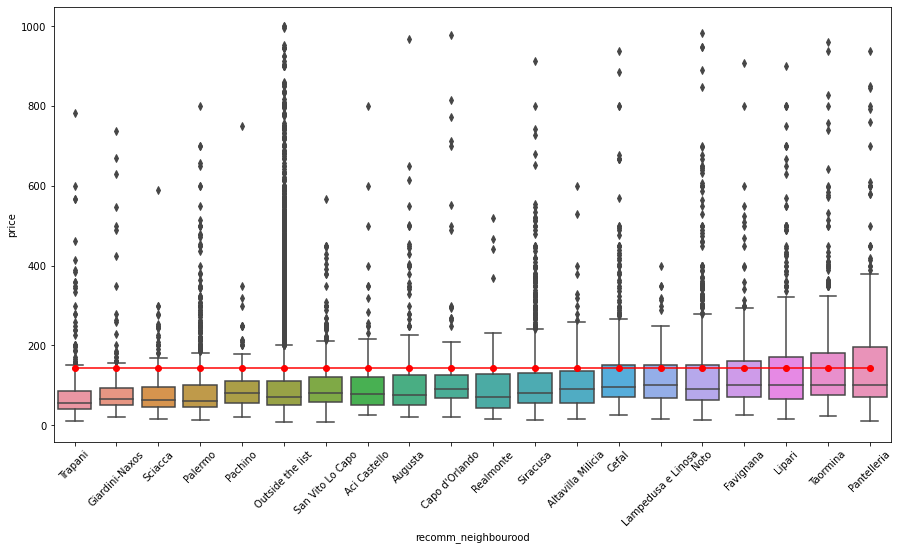

In [53]:
order=listings_target.groupby(by='recomm_neighbourood').quantile(0.75).sort_values(by='price').index
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
plt.xticks(rotation=45)
sns.boxplot(data=listings_target, ax=ax, x='recomm_neighbourood', y="price", order=order)
ax.plot(order, [target_per_night]*20, color='red',marker='o')

As can be seen from the plot, 12 places out of the proposed 19 fall below the requested budget threshold; all the minor islands (Lampedusa, Favignana, Lipari and Pantelleria).
Finally, let's provide the outcome of the inclusion of negotiable requirement on the graph above:

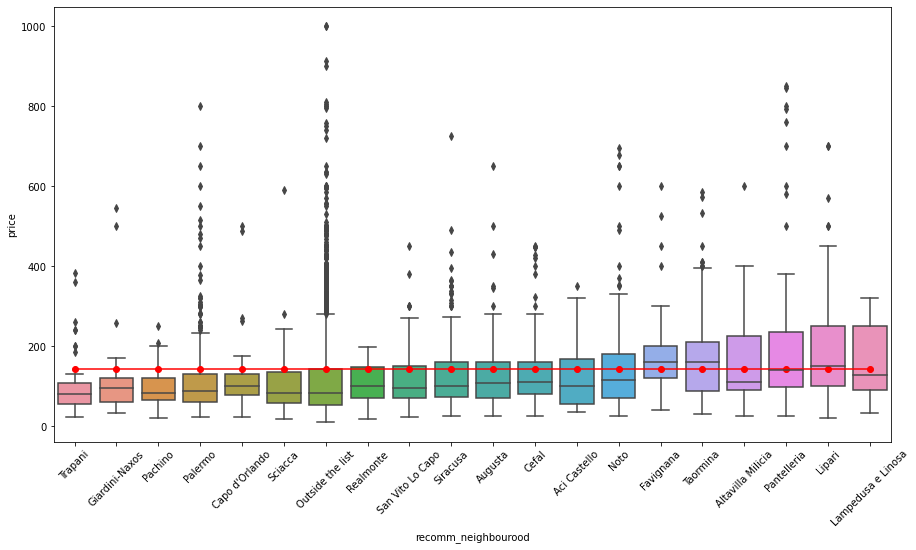

In [54]:
listings_target_negot=listings_target[listings_target['bathrooms']>1]
listings_target_negot=listings_target_negot[listings_target_negot['bedrooms']>1]
listings_target_negot=listings_target_negot[listings_target_negot['review_scores_rating']>90]
order=listings_target_negot.groupby(by='recomm_neighbourood').quantile(0.75).sort_values(by='price').index
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
plt.xticks(rotation=45)
sns.boxplot(data=listings_target_negot, ax=ax, x='recomm_neighbourood', y="price", order=order)
ax.plot(order, [target_per_night]*20, color='red',marker='o')

As visible from the graph, only 6 locations fall within budget constraints if we consider all proposed requirements

## Question 3
The last question is about budget forecast for a specific timeplan downloaded from https://www.voyagetips.com/it/itinerari-2-settimane-in-sicilia/, assumed to start on August 1st. Let's address it as a linear regression task

As a starting point, let's download and store the time plan from the site (using cut & paste). 

1) Catania (2 nights)

2) Siracusa (2 nights)

3) Ragusa (1 nights)

4) Agrigento (1 night)

5) Selinunte (1 night)

6) Trapani (2 nights)

7) Scopello (1 night)

8) Palermo (2 nights)

9) Taormina (2 nights)

The list below set the itinerary as a list of locations 


In [55]:
timelist=['Catania','Catania','Siracusa','Siracusa','Ragusa','Agrigento','Selinunte',
          'Trapani','Trapani','Scopello','Palermo','Palermo','Taormina','Taormina']

In [56]:
set(timelist)-locations

{'Scopello', 'Selinunte'}

Again, we have two recommended locations that do not correspond to administrative units. Let's fix it:

In [57]:
timelist[6]='Castelvetrano'
timelist[9]='Castellammare del Golfo'
set(timelist)-locations

set()

As an exercise, we will try to use a linear regression model to forecast the cost of the accomodation for the travel.
To build the model, we will create a modified dataset with the following columns:

- listing_id: as in current df
- day_plan: datetetime, ranging from August 1st to August 14th
- price: price modified considering the value listed in the 'calendar' dataset (to accomodate for increase of price in high season
- neighbourhood_cleansed: as in current df 
- bedrooms:  : as in current df
- number of bathrooms: as in current df 
- private_room: Boolean
- private_bathroom: Boolean 
- review_scores_rating: as in current df
- minimum_nights: as in current df



In [58]:
listings_short=listings[['id','neighbourhood_cleansed','room_type','bedrooms','beds','bathrooms','private bath', 
                         'price', 'minimum_nights',  'review_scores_rating'
                         ]]
listings_short['private_room']=listings_short['room_type']!="Shared room"
listings_short.drop(columns='room_type',inplace=True)
listings_short=listings_short[listings_short['neighbourhood_cleansed'].isin(timelist)]

<ipython-input-58-e16495fba981>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['private_room']=listings_short['room_type']!="Shared room"
C:\Users\Roberto\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18210 entries, 1 to 49653
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      18210 non-null  int64  
 1   neighbourhood_cleansed  18210 non-null  object 
 2   bedrooms                17714 non-null  float64
 3   beds                    18131 non-null  float64
 4   bathrooms               18178 non-null  float64
 5   private bath            18210 non-null  bool   
 6   price                   18210 non-null  float64
 7   minimum_nights          18210 non-null  int64  
 8   review_scores_rating    12212 non-null  float64
 9   private_room            18210 non-null  bool   
dtypes: bool(2), float64(5), int64(2), object(1)
memory usage: 1.3+ MB


Before moving to a linear regression model, we need to manage NaN values that are still present in the list

It seems reasonable to fill 'review_scores_rating' with an average value and then dropping rows where we miss a value for bedroom, bathroom and beds.

In [60]:
fill_value=listings_short['review_scores_rating'].mean()
listings_short['review_scores_rating'].fillna(value=fill_value, inplace=True)
listings_short.dropna(axis=0,how='any',inplace=True)
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17626 entries, 1 to 49653
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17626 non-null  int64  
 1   neighbourhood_cleansed  17626 non-null  object 
 2   bedrooms                17626 non-null  float64
 3   beds                    17626 non-null  float64
 4   bathrooms               17626 non-null  float64
 5   private bath            17626 non-null  bool   
 6   price                   17626 non-null  float64
 7   minimum_nights          17626 non-null  int64  
 8   review_scores_rating    17626 non-null  float64
 9   private_room            17626 non-null  bool   
dtypes: bool(2), float64(5), int64(2), object(1)
memory usage: 1.2+ MB


We will now try to deploy a linear regression mode based on informations available in listing_short. Intention is to treat location separetely, let's start as an example from Taormina: 

In [61]:
listings_short_loc=listings_short[listings_short['neighbourhood_cleansed']=='Taormina']
X=listings_short_loc.drop(columns=['id','price','neighbourhood_cleansed'])
Y=listings_short_loc['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42) 
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.4886288787343178 on 324 values.'

To finalize the task, we will calculate two different estimation:
- the sum of price per day obtained by a linear regression model
- the convolution of the price distribution per day (assuming, for sake of simplicity, that prices follow a Normal distribution)

Calculation will proceed as follows:

1) Set room requirement for each day in the travelling plan

2) For each day on the vacation plan:
    - Run a linear regression model to have a predictor
    - calculate r-squared score 
    - Estimate the cost of the day inserting room requirement in the predictor
    - Calculate mean and variance of the prices for the accomodation satisfying requirements

3) Sum cost per day estimation to have a total predicted cost

4) Design a normal distribution starting from the lists of means and variances of price per day

5) Draw conclusions

#### step 1 - Set requirement per day
Let's assume that we limit to  mandatoryrequirement in Taormina, Castelvetrano and Castellammare del Golfo, while we want both mandatory and negotiable satisfied in all other location. 

In [62]:
req_bedrooms={}
req_bathrooms={}
req_rating={}

for l in set(timelist):
    req_bedrooms[l]=2
    req_bathrooms[l]=2
    req_rating[l]=80
for l in ['Taormina','Castelvetrano','Castellammare del Golfo']:
    req_bedrooms[l]=2
    req_bathrooms[l]=2
    req_rating[l]=90


#### step 2: main calculation loop

In [63]:
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17626 entries, 1 to 49653
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17626 non-null  int64  
 1   neighbourhood_cleansed  17626 non-null  object 
 2   bedrooms                17626 non-null  float64
 3   beds                    17626 non-null  float64
 4   bathrooms               17626 non-null  float64
 5   private bath            17626 non-null  bool   
 6   price                   17626 non-null  float64
 7   minimum_nights          17626 non-null  int64  
 8   review_scores_rating    17626 non-null  float64
 9   private_room            17626 non-null  bool   
dtypes: bool(2), float64(5), int64(2), object(1)
memory usage: 1.2+ MB


In [64]:
prediction=[]    #list of predicted cost per day
r_square=[]      #list of r_square score fr linear models
convol_mean=0    #Mean of the overall travel cost 
convol_var=0     #Variance of the overall travel cost (we assume all variables are normally distributed so variance of convolution is the sum of variances)

for loc in timelist:   #we scroll the location timeplan
    #we define a dataset we daily location data only
    listings_short_loc=listings_short[listings_short['neighbourhood_cleansed']==loc]  
    
    #preparation of a linear regression model for the day
    X=listings_short_loc.drop(columns=['id','price','neighbourhood_cleansed'])
    Y=listings_short_loc['price']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .30, random_state=42) 
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit
    y_test_preds = lm_model.predict(X_test) 
    r_square.append(r2_score(y_test, y_test_preds))
    # model is trained (we store the r_square score for reference)
    
    #then we run the prediction on a room corresponding to traveler's minimal requirements
    X_req=pd.DataFrame(index=[1],data={'bedrooms':req_bedrooms[loc],'beds':3, 
                                       'bathrooms':req_bathrooms[loc], 'private bath':True,  'minimum_nights':1,
                                       'review_scores_rating':req_rating[loc],'private_room':True})
    y_req = lm_model.predict(X_req) 
    prediction.append(y_req)
    listings_short_loc=listings_short_loc[listings_short_loc['bedrooms']==req_bedrooms[loc]]
    listings_short_loc=listings_short_loc[listings_short_loc['bathrooms']==req_bathrooms[loc]]
    listings_short_loc=listings_short_loc[listings_short_loc['review_scores_rating']>=req_rating[loc]]
    convol_mean+=listings_short_loc['price'].mean()
    convol_var+=listings_short_loc['price'].var()
convol_std=convol_var**0.5
    

#### Step 3: Let's look at prection outcome:

In [65]:
for i in range(len(timelist)):
    print('day {}: {}. Cost per day: {}. Cumulative cost: {}'.format(i+1,timelist[i],int(prediction[i]),sum(prediction[:i+1])))

day 1: Catania. Cost per day: 76. Cumulative cost: [76.01836645]
day 2: Catania. Cost per day: 76. Cumulative cost: [152.0367329]
day 3: Siracusa. Cost per day: 109. Cumulative cost: [261.79751597]
day 4: Siracusa. Cost per day: 109. Cumulative cost: [371.55829903]
day 5: Ragusa. Cost per day: 103. Cumulative cost: [475.27582873]
day 6: Agrigento. Cost per day: 90. Cumulative cost: [565.82800802]
day 7: Castelvetrano. Cost per day: 133. Cumulative cost: [699.79111628]
day 8: Trapani. Cost per day: 100. Cumulative cost: [800.1250449]
day 9: Trapani. Cost per day: 100. Cumulative cost: [900.45897353]
day 10: Castellammare del Golfo. Cost per day: 117. Cumulative cost: [1017.8023666]
day 11: Palermo. Cost per day: 88. Cumulative cost: [1106.1815098]
day 12: Palermo. Cost per day: 88. Cumulative cost: [1194.560653]
day 13: Taormina. Cost per day: 144. Cumulative cost: [1339.42572174]
day 14: Taormina. Cost per day: 144. Cumulative cost: [1484.29079047]


So far so good: it seems the predicted cost (\$1500) is meeting budget constraint!

#### Step 4: Cost distribution 
As said, under the assumptions that all price distributions are normally distributed:

In [66]:
from scipy.stats import norm
cost=[]
prob=[]
perc_not_found=True
for x in range(2,4000, 2):
    y=norm.cdf(x, convol_mean, convol_std)
    cost.append(x)
    prob.append(y)
    if perc_not_found and y >= 0.75:
        perc_75=x-2
        perc_not_found=False

In [67]:
print('Computed average cost: {}'.format(convol_mean))
print('Computed cost standard deviation: {}'.format(convol_std))
print('75th percentile: {}'.format(perc_75))


Computed average cost: 1429.1052175749965
Computed cost standard deviation: 273.6588458486504
75th percentile: 1612


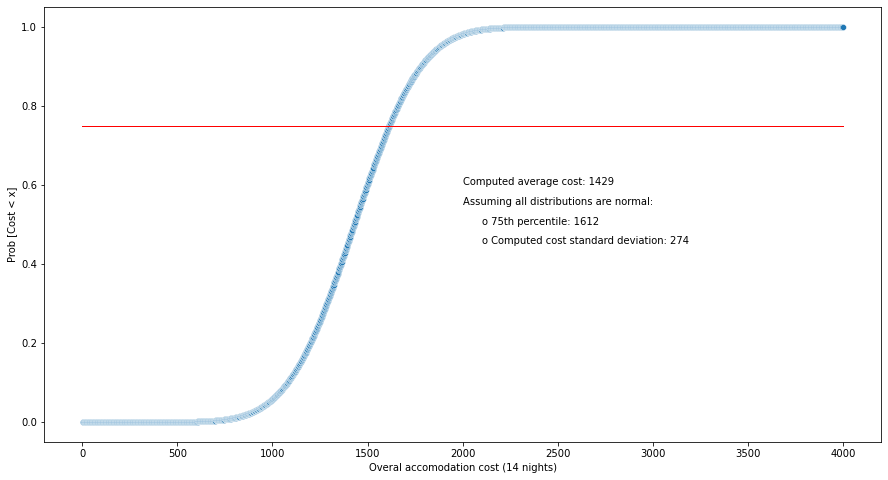

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.scatterplot(x=cost, y=prob)
ax.annotate('Computed average cost: {:.0f}'.format(convol_mean), xy=(2000, .60))
ax.annotate('Assuming all distributions are normal:', xy=(2000, .55))
ax.annotate('o 75th percentile: {:.0f}'.format(perc_75), xy=(2100, .50))
ax.annotate('o Computed cost standard deviation: {:.0f}'.format(convol_std), xy=(2100, .45))
#ax.set(xlim=(10, 1000))
ax.set_xlabel('Overal accomodation cost (14 nights)')
ax.set_ylabel('Prob [Cost < x]')
ax.plot([0, 4000],[0.75,.75], color='red',linewidth=1)